# DengAI: Prevendo a propagação da doença

**D1INT – Introdução à Ciência de Dados**<br />
Especialização em Ciência de Dados - IFSP Campinas

Grupo 05
- Daniel Vargas Shimamoto
- Diego Machado de Assis
- Rafael Sergio Costa

## 0. Motivação

A dengue é uma doença transmitida pelas fêmeas do mosquito Aedes aegypti, que ocorre em partes tropicais e subtropicais do mundo. A cada ano, cerca de 400 milhões de pessoas são infectadas pela dengue, acarretando em cerca de 22 mil mortes por infecções graves. No Brasil, o risco de dengue é classificado como frequente/contínuo. Só em 2020, segundo o ministério da saúde, foram notificados quase 1 milhão de casos prováveis no país. Foram mais de 800 casos graves e mais de 500 óbitos confirmados.

Tendo um mosquito como vetor, a dinâmica de transmissão da dengue está relacionada a variáveis climáticas como *temperatura* e *taxa de precipitação*. As recentes mudanças climáticas que o mundo tem passado podem ter impactos diretos na influência da distribuição global dos vetores dos vírus da dengue. Uma compreensão da relação climática com o potencial da doença pode auxiliar na tomada de decisão das autoridades locais em alocação de recursos e esforços em medidas sanitárias para reduzir os impactos causados pelo vírus. Conseguir realizar predições da dengue de forma mais precisa pode ajudar profissionais de saúde e autoridades sanitárias a antecipar ações e medidas de redução do impacto da epidemia, considerando sua sazonalidade.

## 1. Descrição dos dados

### 1.1. Visão geral

Os dados utilizados e motivação do trabalho são originários de uma [competição](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/) de ciência de dados promovida pelo [DrivenData](https://www.drivendata.org/). O objetivo da competição é de predizer o número total de casos de dengue para dada cidade em determinada semana do ano. Os dados se referem a duas cidades, **San Juan** (Porto Rico) e **Iquitos** (Peru).

O conjunto de dados é composto pelos seguintes arquivos:

| Arquivo | Descrição |
| ------------- | ------------- |
| [Atributos de treinamento][training data features] | Dados das variáveis independenttes para treinamento |
| [Rótulos de treinamento][training data labels]     | Variável dependente: número de cados de dengue para cada amostra do *dataset* de treinamento |
| [Atributos de teste][test data features]           | Dados das variáveis independentes para submissão da competição |
| [Formato de saída][submission format]              | Formato de arquivo esperado para os dados de saída do modelo |

[training data features]: https://github.com/ciencia-dados-ifsp-grupo5/dengAI-dados/blob/main/dengue_features_train.csv

[training data labels]: https://github.com/ciencia-dados-ifsp-grupo5/dengAI-dados/blob/main/dengue_labels_train.csv

[test data features]: https://github.com/ciencia-dados-ifsp-grupo5/dengAI-dados/blob/main/dengue_features_test.csv

[submission format]: https://github.com/ciencia-dados-ifsp-grupo5/dengAI-dados/blob/main/submission_format.csv

### 1.1 Informações dos atributos

Cada linha do *dataset* de atributos tem como chave os valores de `(city, year, weekofyear)`. Ou seja, informações referentes a cada uma das cidades consideradas em uma escala de tempo das semanas do ano.

#### Indicadores de cidade e data

- `city` - Nome da cidade abreviado: `sj` para San Juan e `iq` para Iquitos
- `year` - Ano
- `weekofyear` - Semana do ano
- `week_start_date` - Data de início da semana do ano, no formato `yyyy-mm-dd`

#### Dados de climáticos da base [NOAA GHCN-Daily](https://www.ncdc.noaa.gov/ghcn-daily-description)

- `station_max_temp_c` – Temperatura máxima ($^{\circ}C$)
- `station_min_temp_c` – Temperatura mínima ($^{\circ}C$)
- `station_avg_temp_c` – Temperatura média ($^{\circ}C$)
- `station_precip_mm` – Precipitação total ($mm$)
- `station_diur_temp_rng_c` – Variação da temperatura diurna ($^{\circ}C$)

#### Dados de precipitação do sistema [PERSIANN](https://chrsdata.eng.uci.edu/)

- `precipitation_amt_mm` – Precipitação total ($mm$)

#### Dados climáticos da base [NOAA NCEP Climate Forecast System Reanalysis](https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/climate-forecast-system-version2-cfsv2#CFS%20Reanalysis%20(CFSR))

- `reanalysis_sat_precip_amt_mm` – Precipitação total ($mm$)
- `reanalysis_dew_point_temp_k` – Temperatura média do ponto de orvalho  ($K$)
- `reanalysis_air_temp_k` – Temperatura média do ar ($K$)
- `reanalysis_relative_humidity_percent` – Umidade relativa média (%)
- `reanalysis_specific_humidity_g_per_kg` – Umidade específica média ($g/kg$)
- `reanalysis_precip_amt_kg_per_m2` – Precipitação total ($kg/m^2$)
- `reanalysis_max_air_temp_k` – Temperatura máxima do ar ($K$)
- `reanalysis_min_air_temp_k` – Temperatura mínima do ar ($K$)
- `reanalysis_avg_temp_k` – Temperatura média do ar ($K$)
- `reanalysis_tdtr_k` – Variação da temperatura diurna ($K$)


#### Dados de [Índice de Vegetação por Diferença Normalizada (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) do [NOAA CDR](https://www.ncdc.noaa.gov/cdr/terrestrial/normalized-difference-vegetation-index)

- `ndvi_se` – Pixel sudeste do centroide da cidade
- `ndvi_sw` – Pixel sudoeste do centroide da cidade
- `ndvi_ne` – Pixel nordeste do centroide da cidade
- `ndvi_nw` – Pixel noroeste do centroide da cidade

Com excessão dos *Indicadores de cidade e data*, todos os demais atributos são números reais.

### 1.2 Rótulos

Cada rótulo é definido por `(city, year, weekofyear, total_cases)`. O objetivo do modelo será definir o valor *total de casos* de dengue para cada tupla de *cidade*, *ano* e *semana do ano*.

## 2. Importações

### 2.1. Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de estilo dos gráficos
sns.set_theme(style='white', rc={'axes.titlesize': 18, 'axes.labelsize': 14, 'axes.grid.axis': 'y'})

### 2.2. Datasets

In [2]:
DATAPATH = 'https://github.com/ciencia-dados-ifsp-grupo5/dengAI-dados/blob/main'

features = pd.read_csv(f'{DATAPATH}/dengue_features_train.csv?raw=true')
labels = pd.read_csv(f'{DATAPATH}/dengue_labels_train.csv?raw=true')

In [3]:
features.head(3)

city  year  weekofyear week_start_date  ndvi_ne   ndvi_nw   ndvi_se  \
0   sj  1990          18      1990-04-30  0.12260  0.103725  0.198483   
1   sj  1990          19      1990-05-07  0.16990  0.142175  0.162357   
2   sj  1990          20      1990-05-14  0.03225  0.172967  0.157200   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
0  0.177617                 12.42             297.572857  ...   
1  0.155486                 22.82             298.211429  ...   
2  0.170843                 34.54             298.781429  ...   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                            32.00                             73.365714   
1                            17.94                             77.368571   
2                            26.10                             82.052857   

   reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
0                         12.42                              14.012857   
1                         22.82                              15.372857   
2                         34.54                              16.848571   

   reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
0           2.628571           25.442857                 6.900000   
1           2.371429           26.714286                 6.371429   
2           2.300000           26.714286                 6.485714   

   station_max_temp_c  station_min_temp_c  station_precip_mm  
0                29.4                20.0               16.0  
1                31.7                22.2                8.6  
2                32.2                22.8               41.4  

[3 rows x 24 columns]

In [4]:
labels.head(3)

city  year  weekofyear  total_cases
0   sj  1990          18            4
1   sj  1990          19            5
2   sj  1990          20            4

## 3. Pré-processamento

In [5]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   city         1456 non-null   object
 1   year         1456 non-null   int64 
 2   weekofyear   1456 non-null   int64 
 3   total_cases  1456 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 45.6+ KB


### 3.1. Tipos de dados

O único atributo que não possui o tipo de dado correto é `week_start_date`, que deveria ser uma data. Vamos convertê-lo

In [7]:
features.loc[:, 'week_start_date'] = pd.to_datetime(features.week_start_date)

In [8]:
features.dtypes

city                                             object
year                                              int64
weekofyear                                        int64
week_start_date                          datetime64[ns]
ndvi_ne                                         float64
ndvi_nw                                         float64
ndvi_se                                         float64
ndvi_sw                                         float64
precipitation_amt_mm                            float64
reanalysis_air_temp_k                           float64
reanalysis_avg_temp_k                           float64
reanalysis_dew_point_temp_k                     float64
reanalysis_max_air_temp_k                       float64
reanalysis_min_air_temp_k                       float64
reanalysis_precip_amt_kg_per_m2                 float64
reanalysis_relative_humidity_percent            float64
reanalysis_sat_precip_amt_mm                    float64
reanalysis_specific_humidity_g_per_kg           

### 3.2. Definição dos índices

Vamos definir a chave única de cada registro do *dataset*, ou seja, a tupla `(city, year, weekofyear)`, como índices dos DataFrames

In [9]:
# DataFrame de features
features.set_index(['city', 'year', 'weekofyear'], inplace=True)

# DataFrame de labels
labels.set_index(['city', 'year', 'weekofyear'], inplace=True)

### 3.3. Unidades de medida

Por possuir dados do mesmo fenônemo de fontes diferentes, precisamos padronizar as unidades de medida de alguns deles, para evitar discrepâncias.

#### 3.3.1. Precipitação

Os atributos de precipitação são expressos no *dataset* em duas unidades de medida: milímetros ($mm$) e Quilograma por metro quadrado ($kg/m^2$).

A relação entre elas é a seguinte (considerando que para a água, $1kg = 1 L$):

$$
1\frac{kg}{m^2} = 1\frac{L}{m^2} = 1\frac{dm^3}{m^2} = 1\frac{(10^{-1}m)^3}{m^2} = 1\frac{10^{-3}m^3}{m^2} = 10^{-3}m = 1mm
$$

Portanto, as duas unidades de medida expressam o mesmo valor, e nenhuma conversão precisa ser feita.

#### 3.3.2. Temperatura

Os atributos de temperatura estão expressos em grau Celsius ($^{\circ}C$) e Kelvin ($K$). A conversão dos valores é dada pela [equação](https://www.metric-conversions.org/pt-br/temperatura/celsius-em-kelvin.htm):

$$
K = \mathrm{^{\circ}}C + 273\mathrm{,}15
$$

Vamos padronizar as temperaturas em $K$. Precisamos converter os dados do NOAA GHCN-Daily:

- `station_max_temp_c`
- `station_min_temp_c`
- `station_avg_temp_c`

O atributo `station_diur_temp_rng_c`, apesar de ser uma temperatura dita em $^{\circ}C$, representa de fato uma variação de temperatura. Como valores em $K$ tem a mesma proporção dos $^{\circ}C$, as variações são equivalentes. Portanto, não precisa ser convertido.


In [10]:
features[['station_max_temp_k', 'station_min_temp_k', 'station_avg_temp_k']] = features[['station_max_temp_c', 'station_min_temp_c', 'station_avg_temp_c']] + 273.15
features.drop(columns=['station_max_temp_c', 'station_min_temp_c', 'station_avg_temp_c'], inplace=True)

### 3.4. Divisão dos dados para cada cidade

Como o objetivo final será analisar o padrão de disseminação da dengue e, provavelmente, cada uma das cidades tem suas particularidades, vamos tratar os dados de forma separada para cada uma. Para isso, a primeira coisa a se fazer é separar os datasets em dois conjuntos.

In [11]:
# DataFrames com registros de San Juan
sj_features = features.loc['sj']
sj_labels = labels.loc['sj']

# DataFrames com registros Iquitos
iq_features = features.loc['iq']
iq_labels = labels.loc['iq']

In [12]:
print('SAN JUAN')
print('Atributos:', sj_features.shape)
print('Rótulos  :', sj_labels.shape)
print()
print('IQUITOS')
print('Atributos:', iq_features.shape)
print('Rótulos  :', iq_labels.shape)

SAN JUAN
Atributos: (936, 21)
Rótulos  : (936, 1)

IQUITOS
Atributos: (520, 21)
Rótulos  : (520, 1)


### 3.5. Valores nulos

In [13]:
sj_features.isna().sum()

week_start_date                            0
ndvi_ne                                  191
ndvi_nw                                   49
ndvi_se                                   19
ndvi_sw                                   19
precipitation_amt_mm                       9
reanalysis_air_temp_k                      6
reanalysis_avg_temp_k                      6
reanalysis_dew_point_temp_k                6
reanalysis_max_air_temp_k                  6
reanalysis_min_air_temp_k                  6
reanalysis_precip_amt_kg_per_m2            6
reanalysis_relative_humidity_percent       6
reanalysis_sat_precip_amt_mm               9
reanalysis_specific_humidity_g_per_kg      6
reanalysis_tdtr_k                          6
station_diur_temp_rng_c                    6
station_precip_mm                          6
station_max_temp_k                         6
station_min_temp_k                         6
station_avg_temp_k                         6
dtype: int64

In [14]:
iq_features.isna().sum()

week_start_date                           0
ndvi_ne                                   3
ndvi_nw                                   3
ndvi_se                                   3
ndvi_sw                                   3
precipitation_amt_mm                      4
reanalysis_air_temp_k                     4
reanalysis_avg_temp_k                     4
reanalysis_dew_point_temp_k               4
reanalysis_max_air_temp_k                 4
reanalysis_min_air_temp_k                 4
reanalysis_precip_amt_kg_per_m2           4
reanalysis_relative_humidity_percent      4
reanalysis_sat_precip_amt_mm              4
reanalysis_specific_humidity_g_per_kg     4
reanalysis_tdtr_k                         4
station_diur_temp_rng_c                  37
station_precip_mm                        16
station_max_temp_k                       14
station_min_temp_k                        8
station_avg_temp_k                       37
dtype: int64

Temos valores faltantes em todas as colunas dos DataFrames. Como estamos trabalhando com séries temporais, não podemos simplesmente excluir esses registros.

No caso de San Juan, os dados faltantes são principalmente relacionados ao *Índice de Vegetação*, em especial da região nordeste ao centroide da cidade. Para Iquitos, a maior parte dos valores nulos se refere aos dados de temperatura da da base *NOAA GHCN-Daily*.

Vamos simular como ficaria o preenchimento destes usando uma [interpolação linear](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html) dos valores

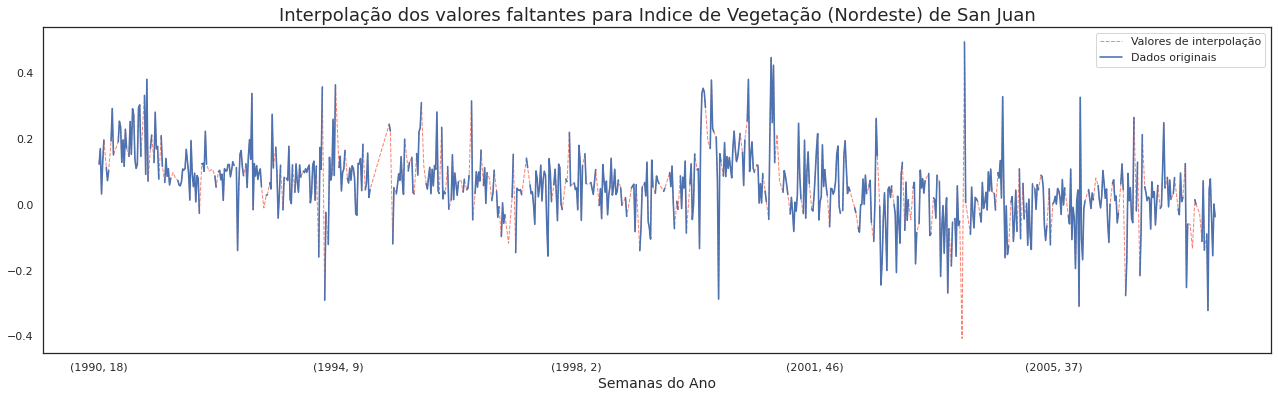

In [15]:
plt.figure(figsize=(22,6))
sj_features.interpolate().ndvi_ne.plot.line(lw=1, color='salmon', label='Valores de interpolação', linestyle = '--')
sj_features.ndvi_ne.plot.line(lw=1.6, label='Dados originais')

plt.title('Interpolação dos valores faltantes para Indice de Vegetação (Nordeste) de San Juan')
plt.xlabel('Semanas do Ano')
plt.legend()
plt.show()

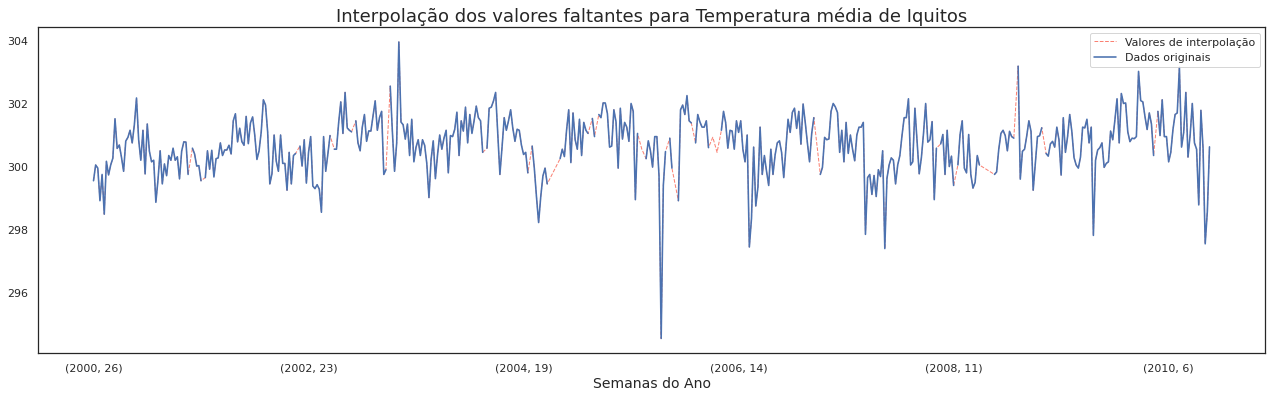

In [16]:
plt.figure(figsize=(22,6))
iq_features.interpolate().station_avg_temp_k.plot.line(lw=1, color='salmon', label='Valores de interpolação', linestyle = '--')
iq_features.station_avg_temp_k.plot.line(lw=1.6, label='Dados originais')

plt.title('Interpolação dos valores faltantes para Temperatura média de Iquitos')
plt.xlabel('Semanas do Ano')
plt.legend()
plt.show()

Tendo estes gráficos como amostragem, nos parece bem razoável utilizar este método para preenchimento dos valores nulos.

In [17]:
# Preenchendo os valores faltantes dos datasets a partir de uma iterpolação linear dos valores adjacentes
sj_features = sj_features.interpolate(axis=0)
iq_features = iq_features.interpolate(axis=0)

In [18]:
# Confirmando que todos os dados faltantes foram preenchidos
(sj_features.isna() & iq_features.isna()).any()

week_start_date                          False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_diur_temp_rng_c                  False
station_precip_mm                        False
station_max_temp_k                       False
station_min_temp_k                       False
station_avg_temp_k                       False
dtype: bool

## 4. Análise Exploratória

A variável alvo `total_cases` é um número inteiro não negativo, o que significa que estamos procurando fazer um modelo de  **previsão de contagem**. As técnicas mais utilizadas para esse tipo de modelo são

1. Regressão de Poisson
2. Regressão Binomial Negativa

Para escolher qual tipo de Regressão utilizar, algumas estatísticas descritivas são necessárias, vamos explorá-las agora.

### 4.1. Análise dos atributos

#### 4.4.1 Precipitação

Existem 4 colunas com dados de precipitação total:
1. `station_precip_mm`
1. `precipitation_amt_mm`
1. `reanalysis_sat_precip_amt_mm`
1. `reanalysis_precip_amt_kg_per_m2`

Vamos analisar como é a distribuição dos valores

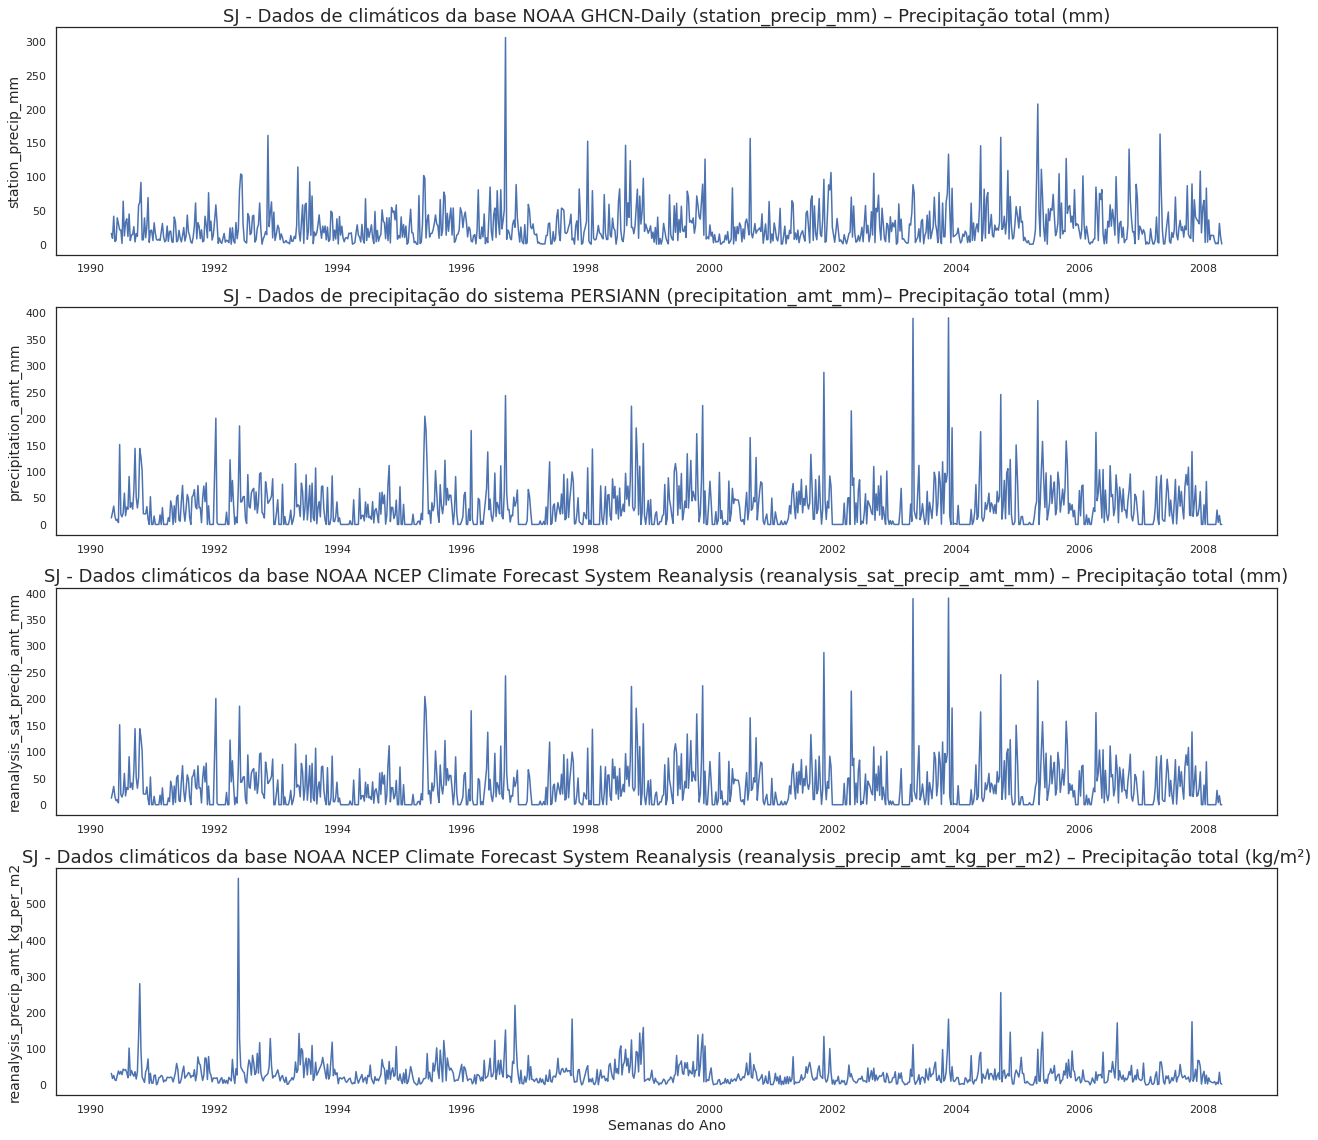

In [19]:
fig, axs = plt.subplots(4, figsize=(18,16))

sns.lineplot(data = sj_features, y = 'station_precip_mm', x = 'week_start_date', ax = axs[0])
axs[0].set_title('SJ - Dados de climáticos da base NOAA GHCN-Daily (station_precip_mm) – Precipitação total (mm)' )
axs[0].set_xlabel('')

sns.lineplot(data = sj_features, y = 'precipitation_amt_mm', x = 'week_start_date',  ax=axs[1])
axs[1].set_title('SJ - Dados de precipitação do sistema PERSIANN (precipitation_amt_mm)– Precipitação total (mm)')
axs[1].set_xlabel('')

sns.lineplot(data = sj_features, y = 'reanalysis_sat_precip_amt_mm', x = 'week_start_date',  ax=axs[2])
axs[2].set_title('SJ - Dados climáticos da base NOAA NCEP Climate Forecast System Reanalysis (reanalysis_sat_precip_amt_mm) – Precipitação total (mm)')
axs[2].set_xlabel('')

sns.lineplot(data = sj_features, y = 'reanalysis_precip_amt_kg_per_m2', x = 'week_start_date',  ax=axs[3])
axs[3].set_title('SJ - Dados climáticos da base NOAA NCEP Climate Forecast System Reanalysis (reanalysis_precip_amt_kg_per_m2) – Precipitação total (kg/m²)')
axs[3].set_xlabel('Semanas do Ano')

plt.tight_layout()
plt.show()

Observando os gráficos, nos parece que as colunas `precipitation_amt_mm` e `reanalysis_sat_precip_amt_mm` possuem os mesmos valores. Vamos verificar as diferenças entre elas

In [20]:
diferenca_colunas = sj_features.precipitation_amt_mm - sj_features.reanalysis_sat_precip_amt_mm
print(f'A diferença máxima entre precipitaion_amt_mm e reanalysis_sat_precip_amt_mm é de {diferenca_colunas.max()}')

A diferença máxima entre precipitaion_amt_mm e reanalysis_sat_precip_amt_mm é de 0.0


Pelas análise da diferença máxima, podemos afirmar que:

`precipitaion_amt_mm` = `reanalysis_sat_precip_amt_mm`

Vamos verificar se o mesmo fenômeno acontece para os dados de **Iquitos**

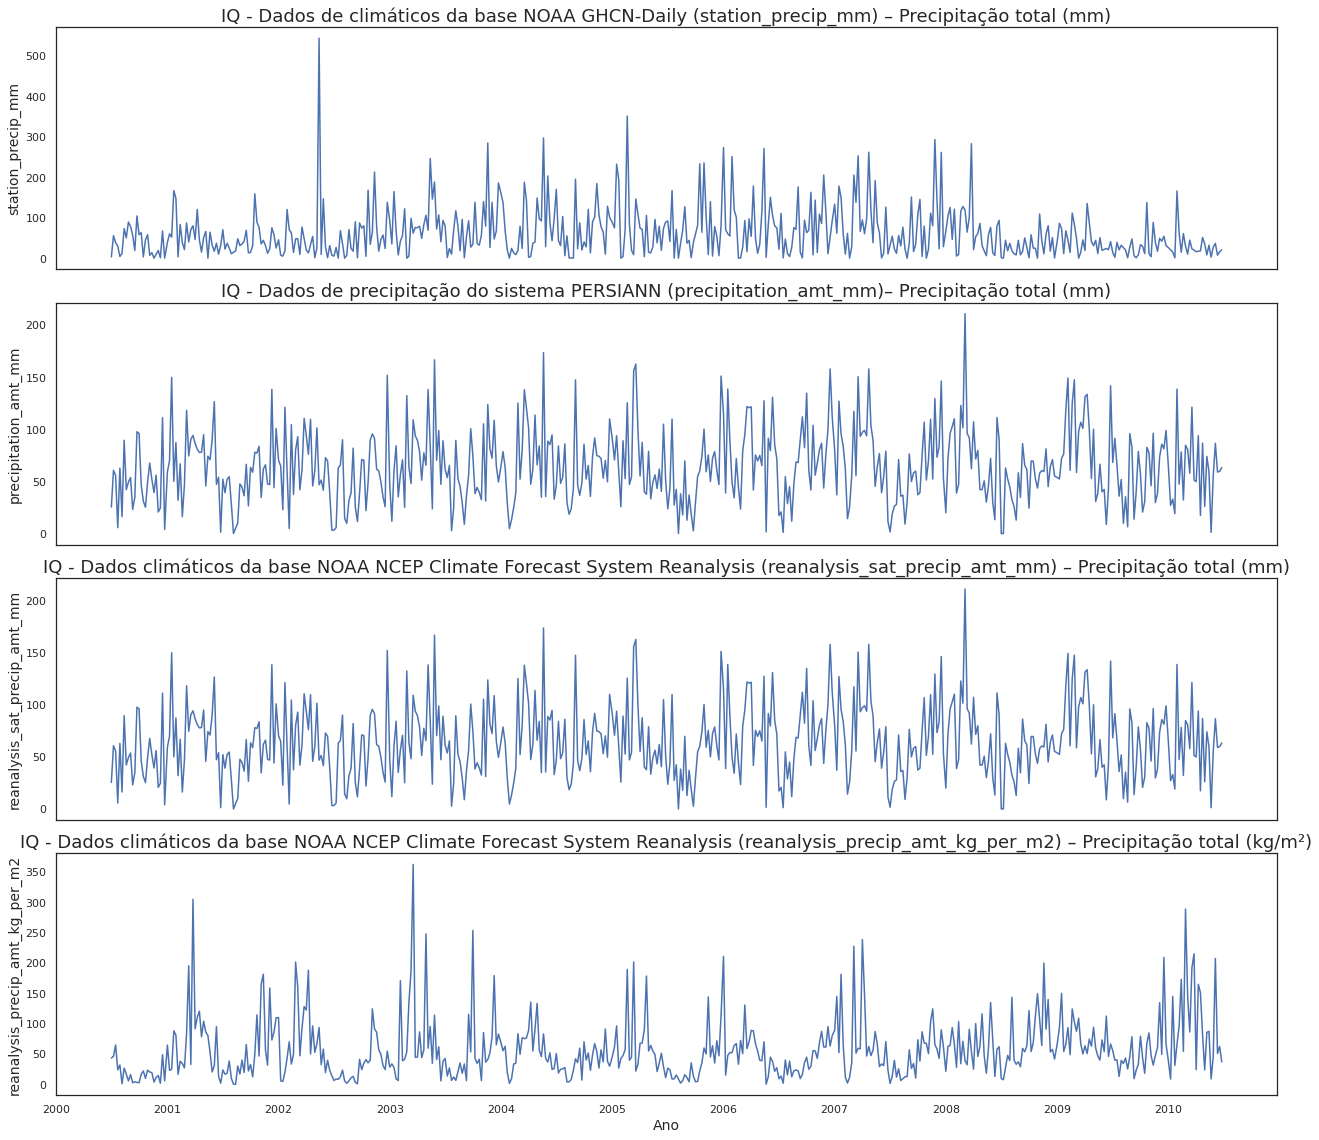

A diferença máxima entre precipitaion_amt_mm e reanalysis_sat_precip_amt_mm é de 0.0


In [21]:
fig, axs = plt.subplots(4, sharex=True, figsize=(18,16))

sns.lineplot(data = iq_features, y = 'station_precip_mm', x = 'week_start_date', ax = axs[0])
axs[0].set_title('IQ - Dados de climáticos da base NOAA GHCN-Daily (station_precip_mm) – Precipitação total (mm)' )
axs[0].set_xlabel('')

sns.lineplot(data = iq_features, y = 'precipitation_amt_mm', x = 'week_start_date',  ax=axs[1])
axs[1].set_title('IQ - Dados de precipitação do sistema PERSIANN (precipitation_amt_mm)– Precipitação total (mm)')
axs[1].set_xlabel('')

sns.lineplot(data = iq_features, y = 'reanalysis_sat_precip_amt_mm', x = 'week_start_date',  ax=axs[2])
axs[2].set_title('IQ - Dados climáticos da base NOAA NCEP Climate Forecast System Reanalysis (reanalysis_sat_precip_amt_mm) – Precipitação total (mm)')
axs[2].set_xlabel('')

sns.lineplot(data = iq_features, y = 'reanalysis_precip_amt_kg_per_m2', x = 'week_start_date',  ax=axs[3])
axs[3].set_title('IQ - Dados climáticos da base NOAA NCEP Climate Forecast System Reanalysis (reanalysis_precip_amt_kg_per_m2) – Precipitação total (kg/m²)')
axs[3].set_xlabel('Ano')

plt.tight_layout()
plt.show()

diferenca_colunas = iq_features.precipitation_amt_mm - iq_features.reanalysis_sat_precip_amt_mm
print(f'A diferença máxima entre precipitaion_amt_mm e reanalysis_sat_precip_amt_mm é de {diferenca_colunas.max()}')

Como as colunas `precipitaion_amt_mm` e `reanalysis_sat_precip_amt_mm` são identicas nas duas cidades, optamos por excluir a coluna `precipitation_amt_mm ` de ambos DF

In [22]:
iq_features.drop(columns = 'precipitation_amt_mm', inplace = True)
sj_features.drop(columns = 'precipitation_amt_mm', inplace = True)

print('SAN JUAN')
print('Atributos: ', sj_features.shape)
print()
print('IQUITOS')
print('Atributos: ', iq_features.shape)

SAN JUAN
Atributos:  (936, 20)

IQUITOS
Atributos:  (520, 20)


#### 4.4.2. Umidade

##### 4.4.2.1. Umidade Relativa

A umidade relativa do ar é a relação entre a quantidade de água existente no ar (umidade absoluta) e a quantidade máxima que poderia haver na mesma temperatura (ponto de saturação). Ela é um dos indicadores usados na meteorologia para se saber como o tempo se comportará (fazer previsões) (https://www.infoescola.com/meteorologia/umidade-relativa-do-ar/).

A informação referente a umidade relativa encontra-se na coluna `reanalysis_relative_humidity_percent`.

Vamos entender como é a distribuição da umidade relativa em ambas as cidades

In [23]:
pd.DataFrame({
    'SJ' : sj_features['reanalysis_relative_humidity_percent'],
    'IQ' : iq_features['reanalysis_relative_humidity_percent']
}).describe().round(2)

SJ      IQ
count  936.00  520.00
mean    78.57   88.66
std      3.38    7.56
min     66.74   57.79
25%     76.25   84.39
50%     78.67   90.92
75%     80.95   94.56
max     87.58   98.61

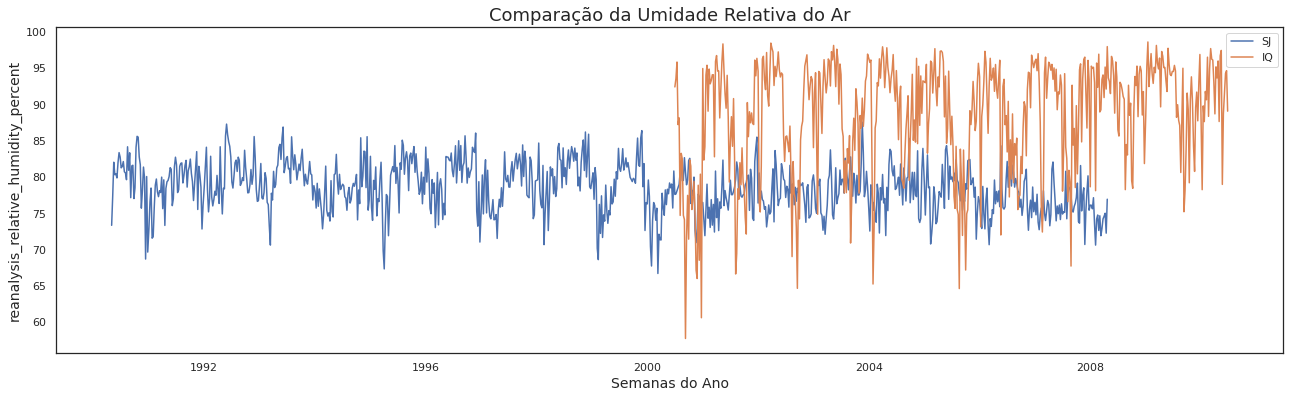

In [24]:
plt.figure(figsize=(22,6))

sns.lineplot(data = sj_features, y = 'reanalysis_relative_humidity_percent', x = 'week_start_date', label = 'SJ')
sns.lineplot(data = iq_features, y = 'reanalysis_relative_humidity_percent', x = 'week_start_date', label = 'IQ')

plt.title('Comparação da Umidade Relativa do Ar')
plt.xlabel('Semanas do Ano')
plt.legend()
plt.show()

Pela tabela e o gráfico apresentado, é possível ver que a variação de umidade relativa do ar em **Iquitos** é muito superior à **San Juan**. Pelo gráfico também é possível perceber a **sazonalidade** anual da variação de umidade. Porém, note como essa sazonalidade é muito mais marcada em Iquitos do que em San Juan. Estes fatores podem indicar que a influência da umidade possar ser bastante relevante para entendermos o cenário de Iquitos.

##### 4.4.2.2. Umidade Específica

A Umidade específica é a razão de vapor de água com o ar (incluindo o próprio vapor de água e o ar seco) em uma massa particular. A razão de humidade específica é expressa como uma razão de gramas (g) de vapor de água por quilograma (kg) da massa de ar úmido total (https://pt.wikipedia.org/wiki/Humidade#Humidade_espec%C3%ADfica).

A informação referente de umidade específica no *dataset* advém da base *NCEP CFSR* e encontra-se na coluna `reanalysis_specific_humidity_g_per_kg`.

In [25]:
pd.DataFrame({
    'SJ' : sj_features['reanalysis_specific_humidity_g_per_kg'],
    'IQ' : iq_features['reanalysis_specific_humidity_g_per_kg']
}).describe().round(2)

SJ      IQ
count  936.00  520.00
mean    16.55   17.10
std      1.56    1.44
min     11.72   12.11
25%     15.23   16.12
50%     16.83   17.44
75%     17.85   18.18
max     19.44   20.46

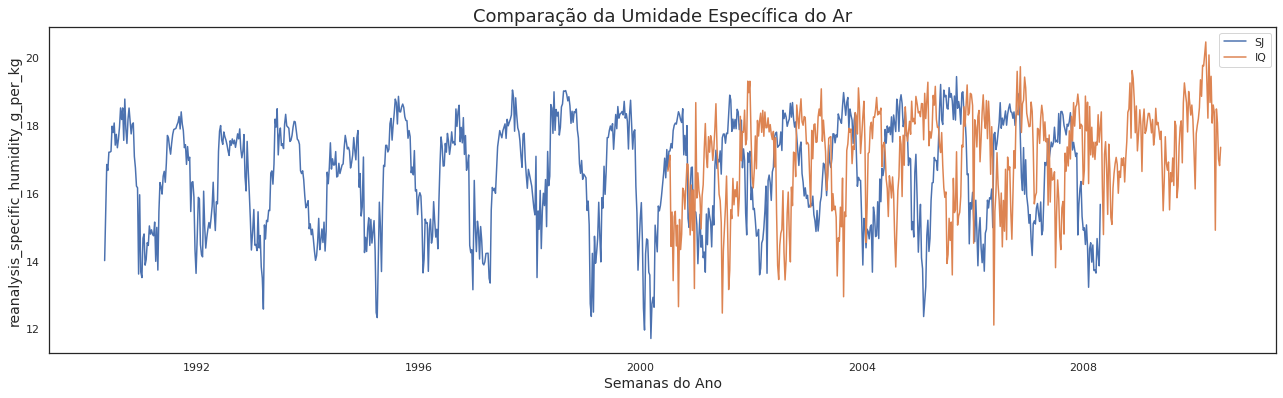

In [26]:
plt.figure(figsize=(22,6))

sns.lineplot(data = sj_features, y = 'reanalysis_specific_humidity_g_per_kg', x = 'week_start_date', label = 'SJ')
sns.lineplot(data = iq_features, y = 'reanalysis_specific_humidity_g_per_kg', x = 'week_start_date', label = 'IQ')

plt.title('Comparação da Umidade Específica do Ar')
plt.xlabel('Semanas do Ano')
plt.legend()
plt.show()

No caso da umidade específica, o comportamento da curva para San Juan é diferente do que vimos anteriormente. A sazonalidade é *mais marcada* e a amplitude de valores passa a ser similar à amplitude de Iquitos.

Interessante notar que as curvas para San Juan e Iquitos estão aproximadamente *meio período deslocadas* uma da outra. Ou seja, de forma geral, o intervalo de crescimento de cada curva coincide com o intervalo de decrescimento da outra, e vice-versa.

##### 4.4.2.3. Correlação entre as medidas de umidade

Vamos observar qual a correlação entre as duas diferentes medidas de umidade para cada uma das cidades

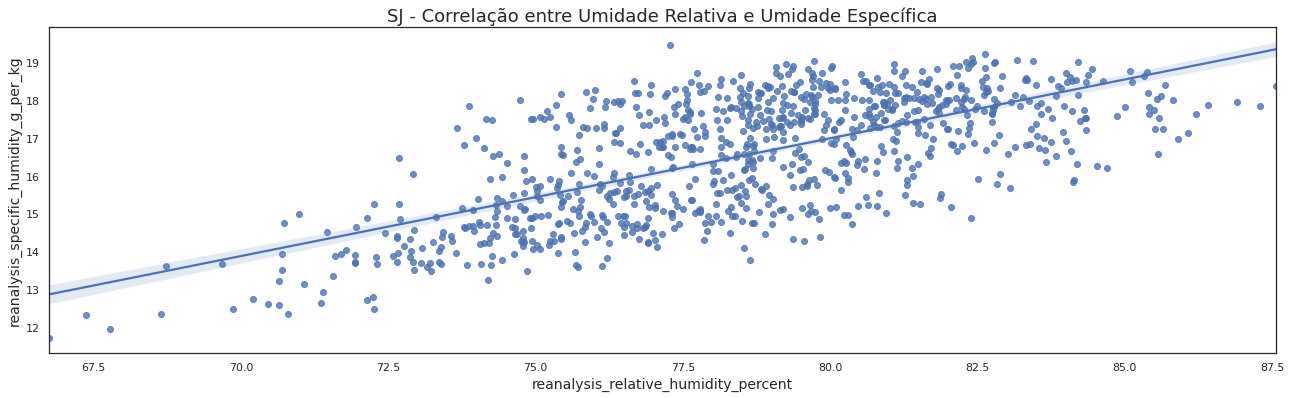

In [27]:
plt.figure(figsize=(22,6))
sns.regplot(data=sj_features, x='reanalysis_relative_humidity_percent', y='reanalysis_specific_humidity_g_per_kg')

plt.title('SJ - Correlação entre Umidade Relativa e Umidade Específica')
plt.show()

In [28]:
sj_features[['reanalysis_relative_humidity_percent', 'reanalysis_specific_humidity_g_per_kg']].corr()

reanalysis_relative_humidity_percent  \
reanalysis_relative_humidity_percent                                1.00000   
reanalysis_specific_humidity_g_per_kg                               0.67301   

                                       reanalysis_specific_humidity_g_per_kg  
reanalysis_relative_humidity_percent                                 0.67301  
reanalysis_specific_humidity_g_per_kg                                1.00000

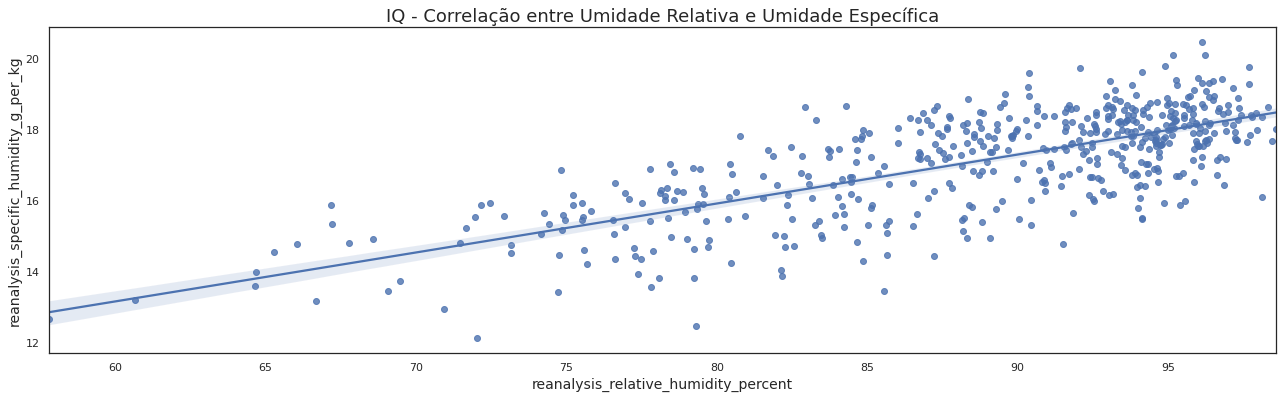

In [29]:
plt.figure(figsize=(22,6))
sns.regplot(data=iq_features, x='reanalysis_relative_humidity_percent', y='reanalysis_specific_humidity_g_per_kg')

plt.title('IQ - Correlação entre Umidade Relativa e Umidade Específica')
plt.show()

In [30]:
iq_features[['reanalysis_relative_humidity_percent', 'reanalysis_specific_humidity_g_per_kg']].corr()

reanalysis_relative_humidity_percent  \
reanalysis_relative_humidity_percent                               1.000000   
reanalysis_specific_humidity_g_per_kg                              0.722881   

                                       reanalysis_specific_humidity_g_per_kg  
reanalysis_relative_humidity_percent                                0.722881  
reanalysis_specific_humidity_g_per_kg                               1.000000

Os gráficos e valores acima confimam nossa expectativa de que a correlação entre as medidas de umidade seriam maiores em Iquitos (0,72) do que em San Juan (0,67). Isto porque no ítem e 4.4.2.1 vimos como o gráfico de umidade relativa para San Juan tinha períodos menos definidos que o apresentado no gráfico seguinte, de umidade específica.

Porém, em ambos os casos podemos ver que existe uma correlação de moderada a forte, sendo significativa para a modelagem que faremos futuramente.

#### 4.4.3. Variação da Temperatura Diurna

Existem 2 atributos que expressão a varição de temperatura durante o dia:

1. `station_diur_temp_rng_c` –  Variação da temperatura diurna ($^oC$)
2. `reanalysis_tdtr_k ` – Variação da temperatura diurna ($K$)

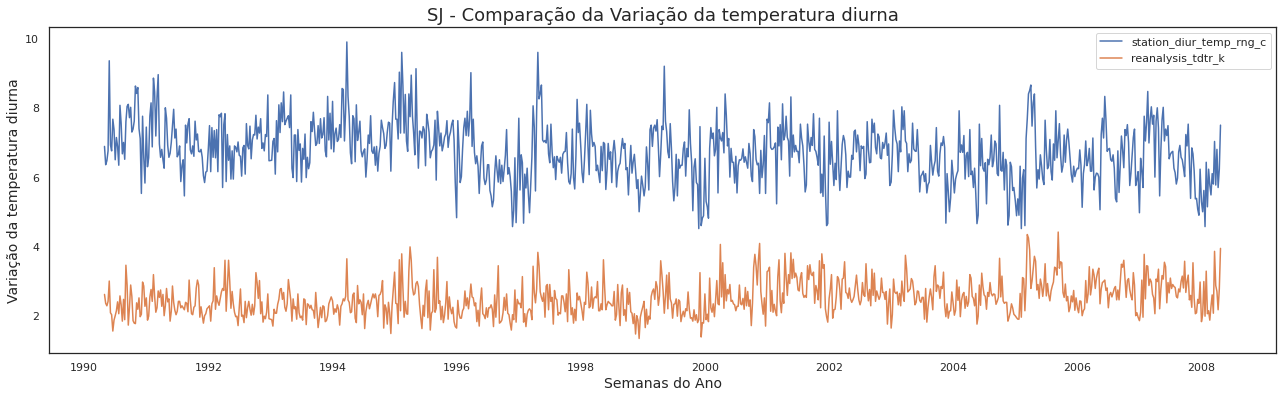

In [31]:
# Gráfico de linha
plt.figure(figsize=(22,6))
sns.lineplot(data = sj_features, y = 'station_diur_temp_rng_c', x = 'week_start_date', label = 'station_diur_temp_rng_c')
sns.lineplot(data = sj_features, y = 'reanalysis_tdtr_k', x = 'week_start_date', label = 'reanalysis_tdtr_k')

plt.title('SJ - Comparação da Variação da temperatura diurna')
plt.xlabel('Semanas do Ano')
plt.ylabel('Variação da temperatura diurna')
plt.legend()
plt.show()

A análise dos valores em **San Juan** mostra que a distribuição da Variação da Temperatura Diurna é **diferente** entre as medições.

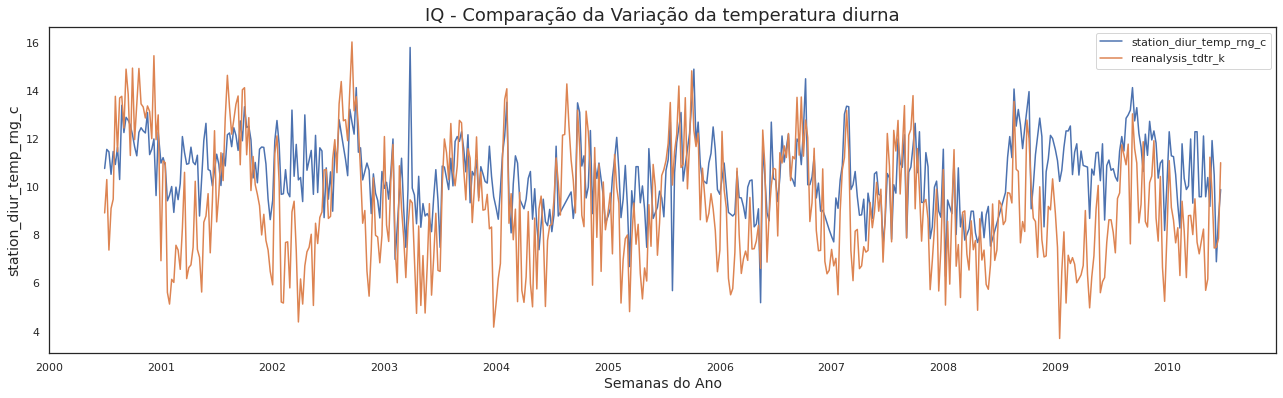

In [32]:
# Gráfico de linha
plt.figure(figsize=(22,6))
sns.lineplot(data = iq_features, y = 'station_diur_temp_rng_c', x = 'week_start_date', label = 'station_diur_temp_rng_c')
sns.lineplot(data = iq_features, y = 'reanalysis_tdtr_k', x = 'week_start_date', label = 'reanalysis_tdtr_k')

plt.title('IQ - Comparação da Variação da temperatura diurna')
plt.xlabel('Semanas do Ano')
plt.legend()
plt.show()

A análise da Temperatura em **Iquitos** mostra que a distribuição da Variação da Temperatura Diurna possuem valores **diferentes** em cada medição.

Curioso notar como as medições da base *GHCN-Daily* e *NCEP CSFR* são diferentes entre as duas cidades. Para **San Juan** os valores são muito mais distantes do que para **Iquitos**.

#### 4.4.4. Temperatura

##### 4.4.4.1. Temperatura Média

Três atributos são informativos da temperatura média:

1. `station_avg_temp_k`
1. `reanalysis_air_temp_k`
1. `reanalysis_avg_temp_k`

Sendo o primeiro do *GHCN-Daily* e os dois últimos do *NCEP CFSR*.

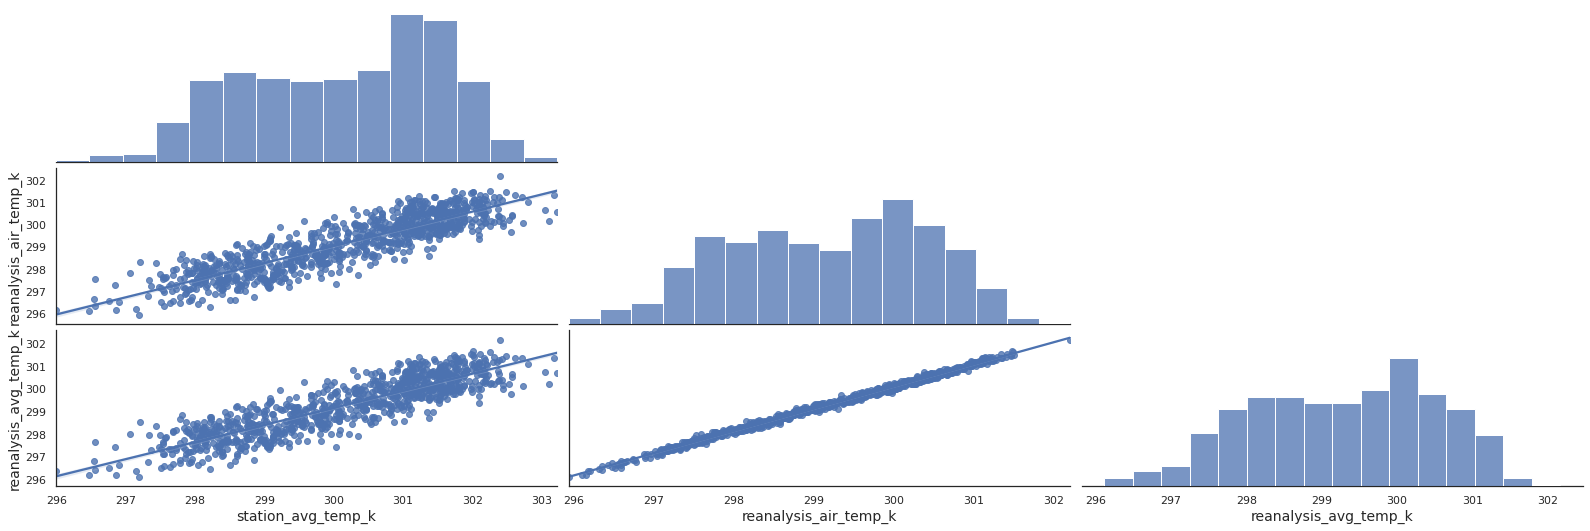

In [33]:
# Relação entre as temperaturas médias de San Juan
sns.pairplot(sj_features[['station_avg_temp_k', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k']], kind='reg', corner=True, aspect=3)
plt.show()

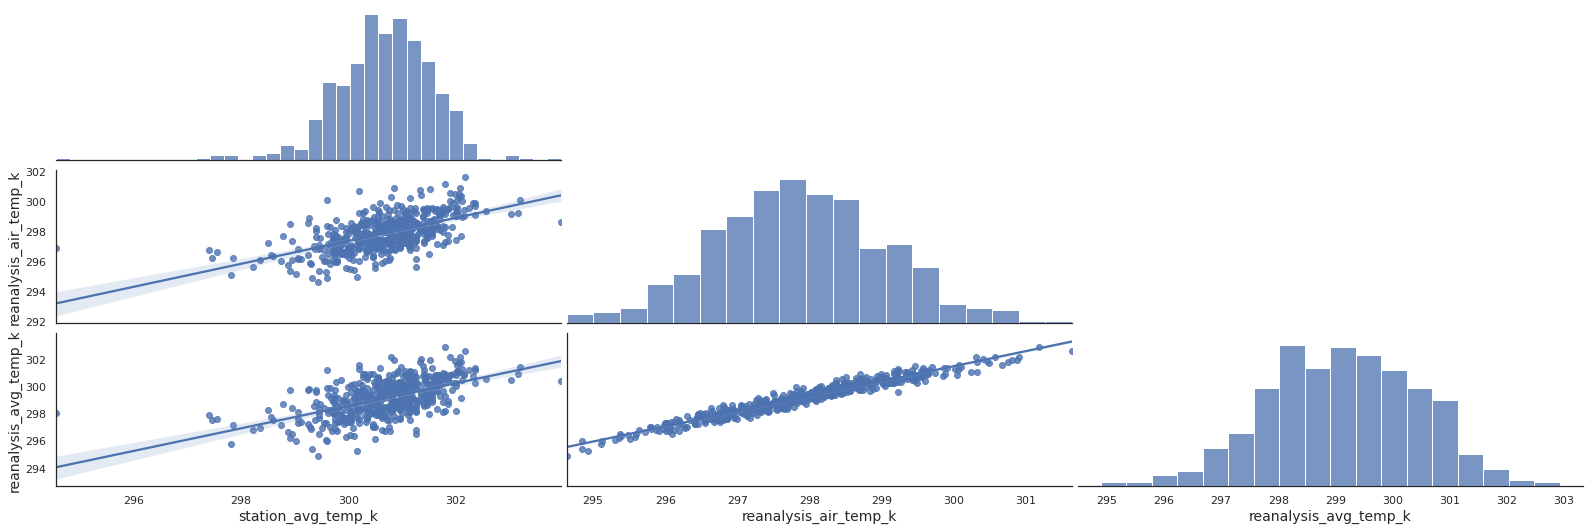

In [34]:
# Relação entre as temperaturas médias de Iquitos
sns.pairplot(iq_features[['station_avg_temp_k', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k']], kind='reg', corner=True, aspect=3)
plt.show()

Os gráficos acima mostram que os atributos oriundos do *NCEP CFSR* possuem uma correlação positiva quase perfeita tanto para San Juan quanto para Iquitos.

Comparados com os dados do *GHCN-Daily*, os dados de San Juan são mais consistentes, apresentando também uma forte correlação. Já os dados de Iquitos estão um pouco menos correlacionados, mostrando alguma diferença entre as séries das duas bases de dados.

##### 4.4.4.2. Temperaturas máximas e mínimas

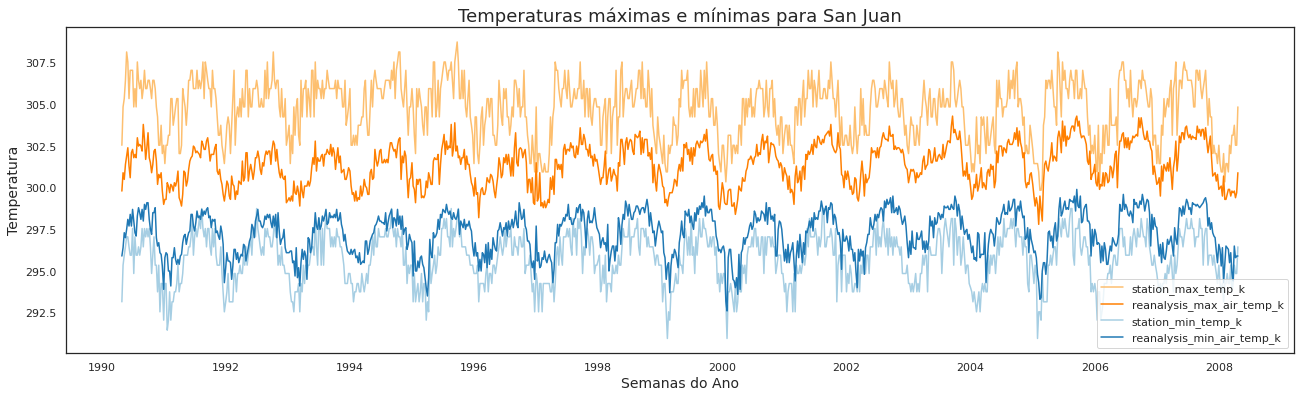

In [35]:
plt.figure(figsize=(22,6))

cmap = sns.color_palette("Paired")

# Temperaturas máximas
sns.lineplot(data = sj_features, y = 'station_max_temp_k', x = 'week_start_date', label = 'station_max_temp_k', color=cmap[6])
sns.lineplot(data = sj_features, y = 'reanalysis_max_air_temp_k', x = 'week_start_date', label = 'reanalysis_max_air_temp_k', color=cmap[7])

# Temperaturas mínimas
sns.lineplot(data = sj_features, y = 'station_min_temp_k', x = 'week_start_date', label = 'station_min_temp_k', color=cmap[0])
sns.lineplot(data = sj_features, y = 'reanalysis_min_air_temp_k', x = 'week_start_date', label = 'reanalysis_min_air_temp_k', color=cmap[1])

plt.title('Temperaturas máximas e mínimas para San Juan')
plt.xlabel('Semanas do Ano')
plt.ylabel('Temperatura')
plt.legend()
plt.show()

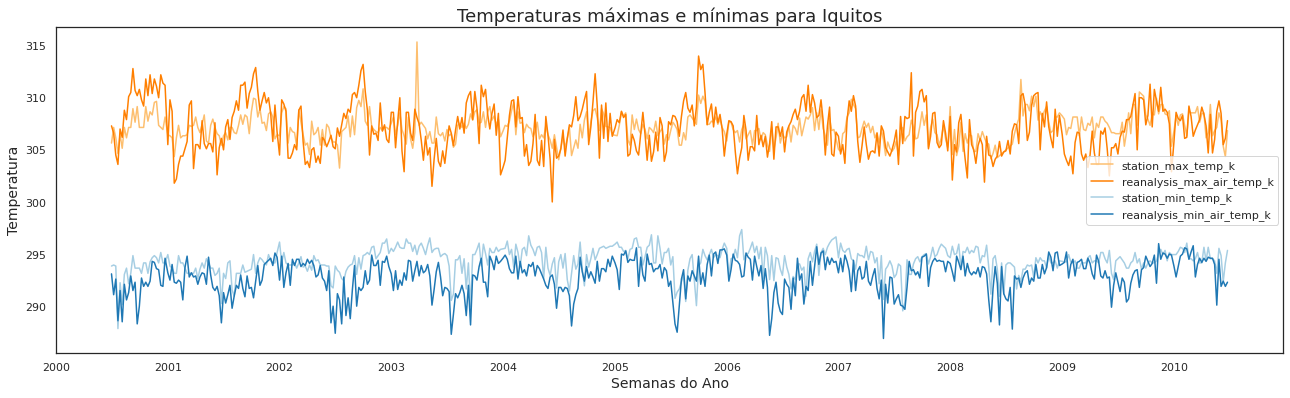

In [36]:
plt.figure(figsize=(22,6))

cmap = sns.color_palette("Paired")

# Temperaturas máximas
sns.lineplot(data = iq_features, y = 'station_max_temp_k', x = 'week_start_date', label = 'station_max_temp_k', color=cmap[6])
sns.lineplot(data = iq_features, y = 'reanalysis_max_air_temp_k', x = 'week_start_date', label = 'reanalysis_max_air_temp_k', color=cmap[7])

# Temperaturas mínimas
sns.lineplot(data = iq_features, y = 'station_min_temp_k', x = 'week_start_date', label = 'station_min_temp_k', color=cmap[0])
sns.lineplot(data = iq_features, y = 'reanalysis_min_air_temp_k', x = 'week_start_date', label = 'reanalysis_min_air_temp_k', color=cmap[1])

plt.title('Temperaturas máximas e mínimas para Iquitos')
plt.xlabel('Semanas do Ano')
plt.ylabel('Temperatura')
plt.legend()
plt.show()

As temperaturas máximas e mínimas oscilam de forma similar entre as bases de dados e cidades consideradas. Como notado em outros atributos, parece haver um *deslocamento* entre os valores do *GHCN-Daily* e *NCEP CFSR* em San Juan. Para Iquitos, os valores das diferentes bases são mais próximos.

##### 4.4.4.3 Correlação entre as temperaturas

Como possuímos vários atributos de temperatura, pode ser interessante entender a correlação entre eles. Isto pode nos ajudar a melhor selecionar os atributos que devem ser considerado quando estivermos treinando nosso modelo de aprendizado.

Além dos atributos mostrados nos pontos anterior (de temperaturas médias, máximas e mínimas), vamos também considerar a coluna `reanalysis_dew_point_temp_k`, da temperatura do ponto de orvalho da base *NCEP CFSR*.

In [37]:
features_temperatura = [
    'station_max_temp_k',
    'station_min_temp_k',
    'station_avg_temp_k',
    'reanalysis_dew_point_temp_k',
    'reanalysis_air_temp_k',
    'reanalysis_max_air_temp_k',
    'reanalysis_min_air_temp_k',
    'reanalysis_avg_temp_k'
]

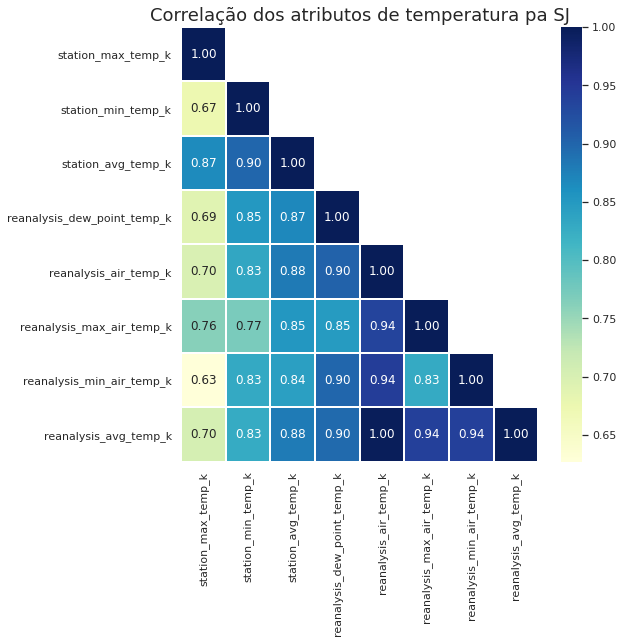

In [38]:
corr = sj_features[features_temperatura].corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(8,8))
sns.heatmap(corr, mask=mask, linewidths=.3, cmap="YlGnBu", annot = True, fmt = '.2f')
plt.title('Correlação dos atributos de temperatura pa SJ')
plt.show()

Os dados de temperatura para San Juan são fortemente correlacionados entre si. O atributo `station_max_temp_k` é levemente mais distante dos outros. Mas no geral, são atributos que seguem um padrão de variação muito similar entre os registros.

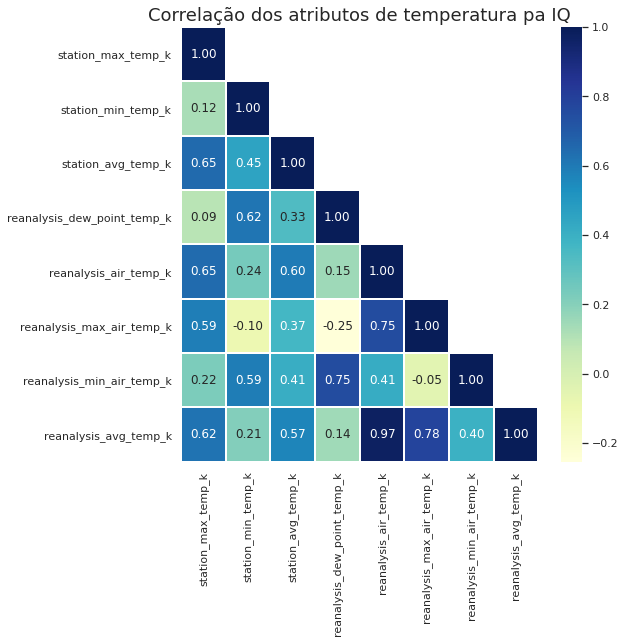

In [39]:
corr = iq_features[features_temperatura].corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(8,8))
sns.heatmap(corr, mask=mask, linewidths=.3, cmap="YlGnBu", annot = True, fmt = '.2f')
plt.title('Correlação dos atributos de temperatura pa IQ')
plt.show()

Diferente do padrão observado para San Juan, os dados de temperatura de Iquitos são pouco correlacionados entre si. Curioso notar que em alguns casos a correlação chega a ser (fracamente) negativa, que é contraintuitivo, uma vez que sempre esperamos que as diferentes medidas de temperatura sejam diretamente proporcionais entre si.

No momento de produzir nosso modelo, teremos que levar em conta estas diferenças entre as cidades

#### 4.4.5. Índice de Vegetação

In [40]:
# Correlação entre índices de vegetação os diferentes pontos de SJ
sj_features[['ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_nw']].corr()

ndvi_se   ndvi_sw   ndvi_ne   ndvi_nw
ndvi_se  1.000000  0.814621  0.219353  0.197311
ndvi_sw  0.814621  1.000000  0.181035  0.217740
ndvi_ne  0.219353  0.181035  1.000000  0.632660
ndvi_nw  0.197311  0.217740  0.632660  1.000000

A tabela de correlações acima nos mostra uma separação muito clara entre os índices de vegetação das regiões **norte** e **sul** de San Juan. Note como se correlacionam mais fortemente as regiões sudeste e sudoeste (0,82) e nordeste e noroeste (0,67). As outras correlações (comparando regiões ao norte com regiões ao sul) são todas fracas.

In [41]:
# Correlação entre índices de vegetação os diferentes pontos de IQ
iq_features[['ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_nw']].corr()

ndvi_se   ndvi_sw   ndvi_ne   ndvi_nw
ndvi_se  1.000000  0.715192  0.769360  0.644541
ndvi_sw  0.715192  1.000000  0.842922  0.765389
ndvi_ne  0.769360  0.842922  1.000000  0.764200
ndvi_nw  0.644541  0.765389  0.764200  1.000000

Já para Iquitos, o cenário é bem diferente. Todos os pontos de vegetação possuem [correlação forte](https://pt.wikipedia.org/wiki/Coeficiente_de_correla%C3%A7%C3%A3o_de_Pearson#Interpretando_%7F'%22%60UNIQ--postMath-0000000A-QINU%60%22'%7F[1]) entre si.

#### 4.4.6. Correlação dos Atribuitos

Vamons entender como é a correlação entre todas as variáveis

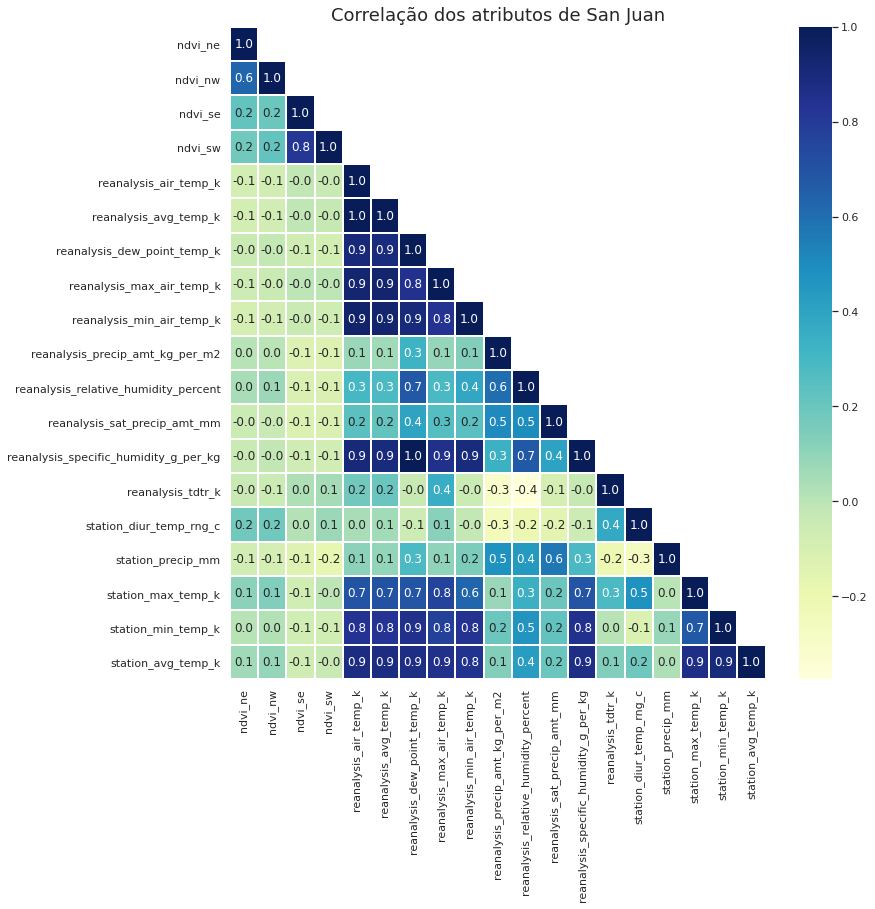

In [42]:
mask = np.zeros_like(sj_features.corr())
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(12,12))
sns.heatmap(sj_features.corr(), linewidths=.3, cmap="YlGnBu", annot = True, fmt = '.1f', mask = mask)
plt.title('Correlação dos atributos de San Juan')
plt.show()

Para San Juan, como havíamos notado anteriormente, existe uma forte correlação entre os atributos de temperatura. Além disso, podemos ver também uma correlação muito forte entre Umidade Específica (`ranalysis_specific_humidity_g_per_kg`) e as temperaturas.

Como também já dito anteriormente, os indíces de vegetação ao norte e ao sul correlacionam-se fortemente. Também é o caso entre a Umidade Relativa (`reanalysis_relative_humidity_percent`) e a umidade específica e a temperatura do ponto de orvalho.

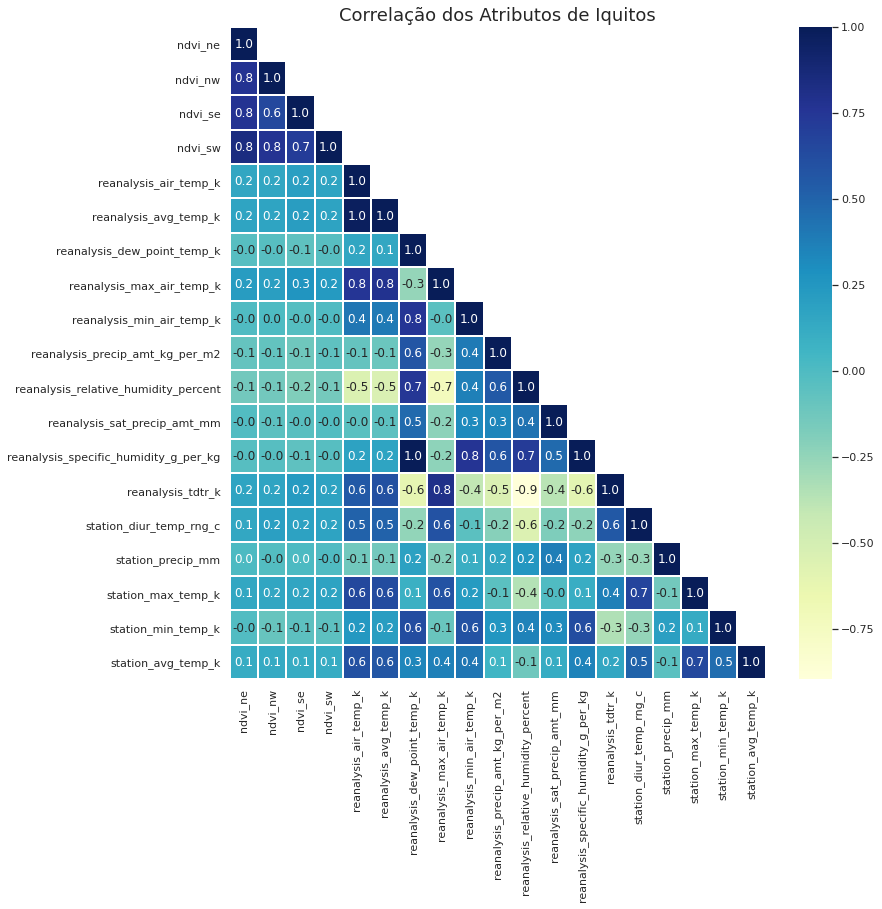

In [43]:
mask = np.zeros_like(iq_features.corr())
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(12,12))
sns.heatmap(iq_features.corr(), linewidths=.3, cmap="YlGnBu", annot = True, fmt = '.1f', mask = mask)
plt.title('Correlação dos Atributos de Iquitos')
plt.show()

Para Iquitos, os atributos são menos correlacionados entre si, no geral. Possuem forte correlação entre si os ìndices de Vegetação, como observado anteriormente. Também se correlacionam fortemente as temperaturas médias e as umidades entre si e com algumas temperaturas. Existe uma correlação muito forte entre umidade específica e temperatura do ponto de orvalho.

É interessante notar a correlação fortemente negativa, entre umidade relativa (`reanalysis_relative_humidity_percent`) e  variação da temperatura diurna (`reanalysis_tdtr_k`).

### 4.2. Análise dos Rótulos

In [44]:
# Total de casos das duas cidades
total_casos = pd.concat([sj_labels, iq_labels], axis=1)
total_casos.columns = ['San Juan', 'Iquitos']

In [45]:
total_casos.head(3)

San Juan  Iquitos
year weekofyear                   
1990 18               4.0      NaN
     19               5.0      NaN
     20               4.0      NaN

#### 4.2.1. Número de casos de dengue ao longo do tempo

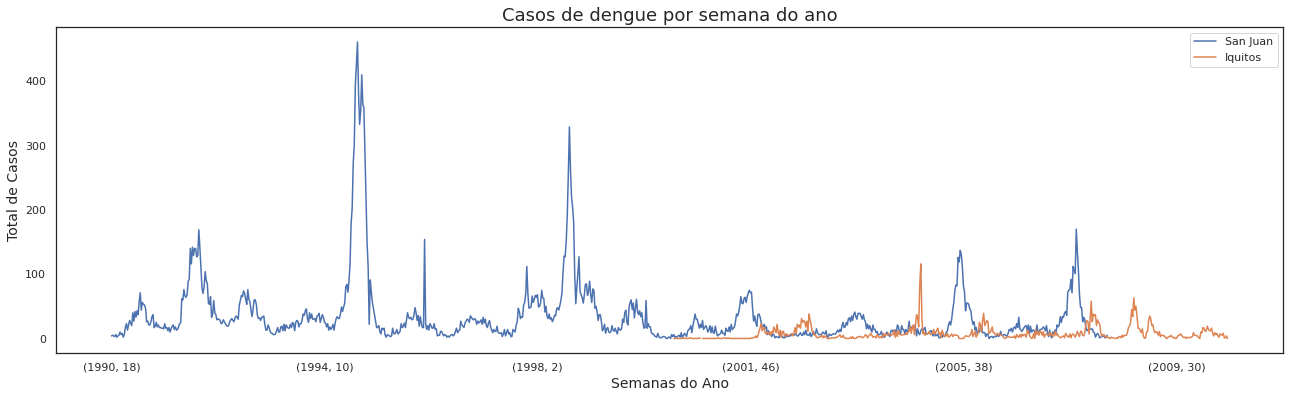

In [46]:
fig, ax = plt.subplots(figsize=(22,6))

total_casos.plot.line(ax=ax)

plt.title('Casos de dengue por semana do ano')
plt.xlabel('Semanas do Ano')
plt.ylabel('Total de Casos')
plt.show()

Podemos também agregar os casos por ano, de forma a ter uma visão mais geral do cenário

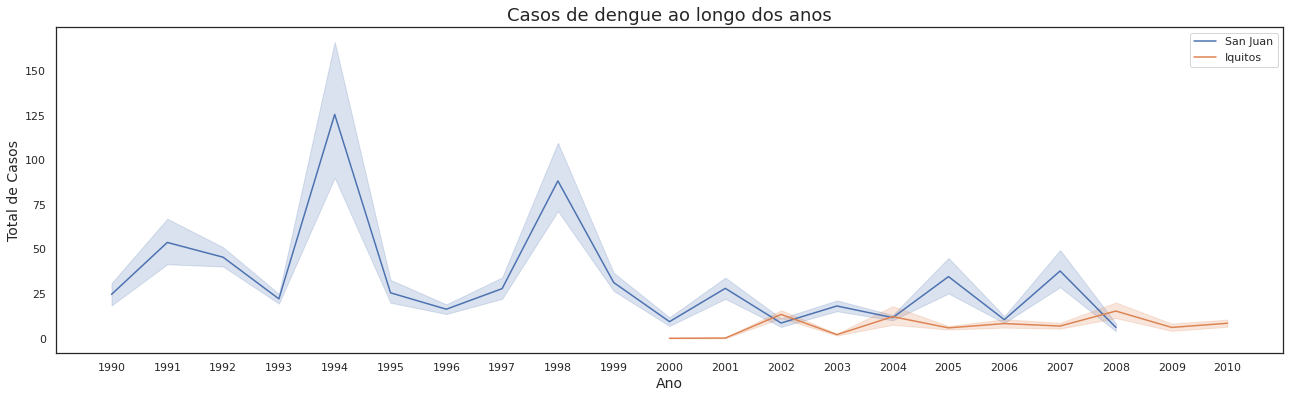

In [47]:
plt.figure(figsize=(22,6))

sns.lineplot(data = sj_labels, x = 'year', y = 'total_cases', label = 'San Juan')
sns.lineplot(data = iq_labels, x = 'year', y = 'total_cases', label = 'Iquitos')

plt.title('Casos de dengue ao longo dos anos', fontsize = 18)
plt.xlabel('Ano', fontsize = 14)
plt.ylabel('Total de Casos', fontsize = 14)
plt.xticks(range(1990,2011))

plt.legend()
plt.show()

É possível ver que a quantidade de casos na cidade de San Juan é, no geral, superior aos casos da cidade de Iquitos. Existem alguns picos bem aparentes em ambas as cidades, indicando os momentos de surto epidêmico do vírus.

#### 4.2.2. Estatísticas da quantidade de casos

Vamos analisar algumas estatísticas descritivas sobre a quantidade de casos de cada uma das cidades, para entender um pouco melhor como os dados estão distribuídos.

In [48]:
total_casos.describe().round(2)

San Juan  Iquitos
count    936.00   520.00
mean      34.18     7.57
std       51.38    10.77
min        0.00     0.00
25%        9.00     1.00
50%       19.00     5.00
75%       37.00     9.00
max      461.00   116.00

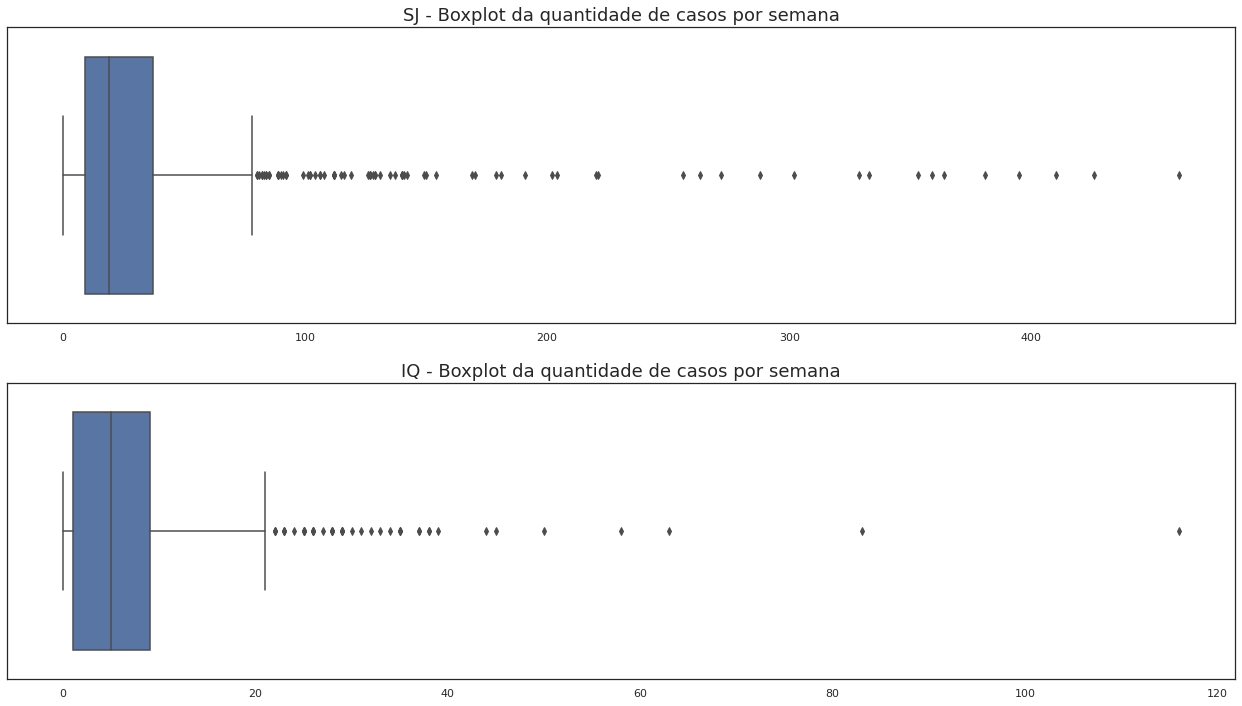

In [49]:
fig, axs = plt.subplots(2, figsize=(22,12))

sns.boxplot(x=sj_labels['total_cases'], ax = axs[0])
axs[0].set_title('SJ - Boxplot da quantidade de casos por semana' )
axs[0].set_xlabel('')

sns.boxplot(x=iq_labels['total_cases'], ax = axs[1])
axs[1].set_title('IQ - Boxplot da quantidade de casos por semana')
axs[1].set_xlabel('')

plt.show()

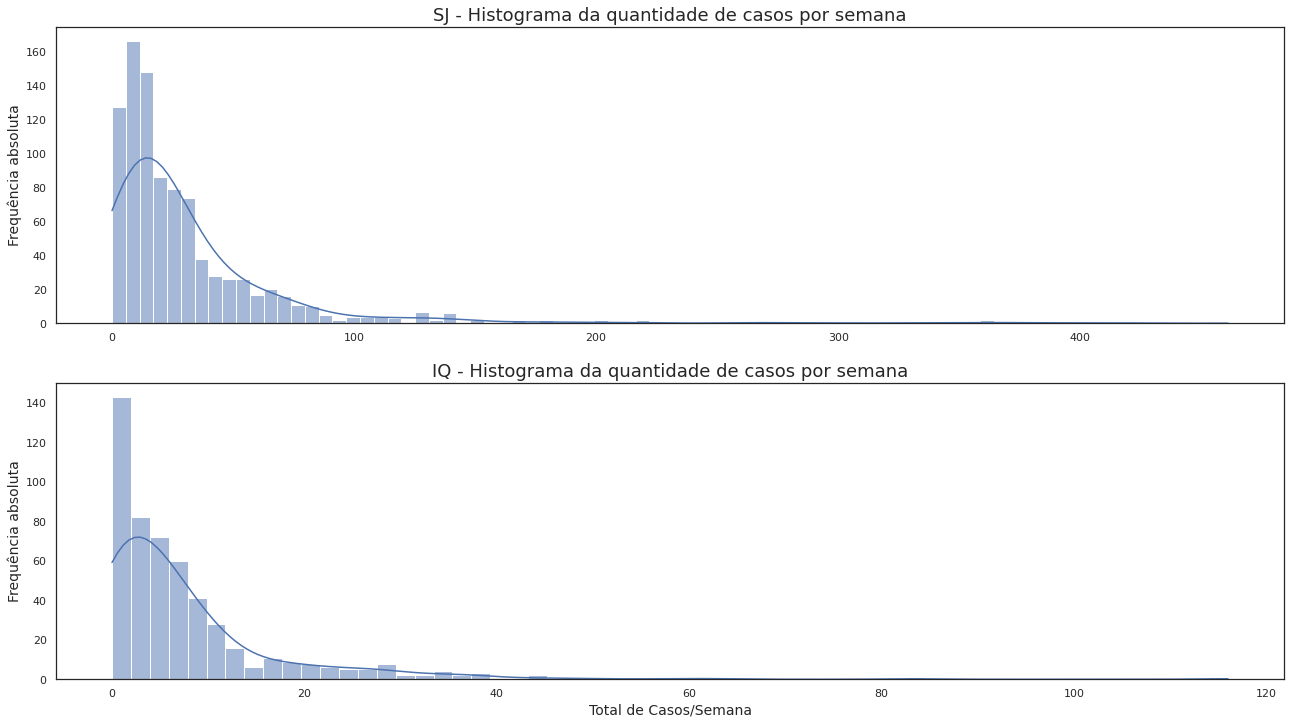

In [50]:
fig, axs = plt.subplots(2, figsize=(22,12))

sns.histplot(data = sj_labels, x = 'total_cases', ax = axs[0], kde = True)
axs[0].set_title('SJ - Histograma da quantidade de casos por semana' )
axs[0].set_xlabel('')
axs[0].set_ylabel('Frequência absoluta')

sns.histplot(data = iq_labels, x = 'total_cases', ax = axs[1], kde = True)
axs[1].set_title('IQ - Histograma da quantidade de casos por semana')
axs[1].set_xlabel('Total de Casos/Semana')
axs[1].set_ylabel('Frequência absoluta')

plt.show()

Pelos gráficos e pelas estatísticas, é possível verificar que a cidade de **San Juan** tem uma quantidade média de casos superior à cidade **Iquitos**. Além disso, o desvio padrão é maior do que a média em ambas as cidades, podendo ser descrita como uma [Distribuição Binomial Negativa](https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_binomial_negativa)

#### 4.2.3. Média móvel do número de casos de dengue

In [51]:
MM_casos = total_casos.copy()
MM_casos[['MM San Juan', 'MM Iquitos']] = total_casos.rolling(4).mean()

In [52]:
MM_casos.head()

San Juan  Iquitos  MM San Juan  MM Iquitos
year weekofyear                                            
1990 18               4.0      NaN          NaN         NaN
     19               5.0      NaN          NaN         NaN
     20               4.0      NaN          NaN         NaN
     21               3.0      NaN          4.0         NaN
     22               6.0      NaN          4.5         NaN

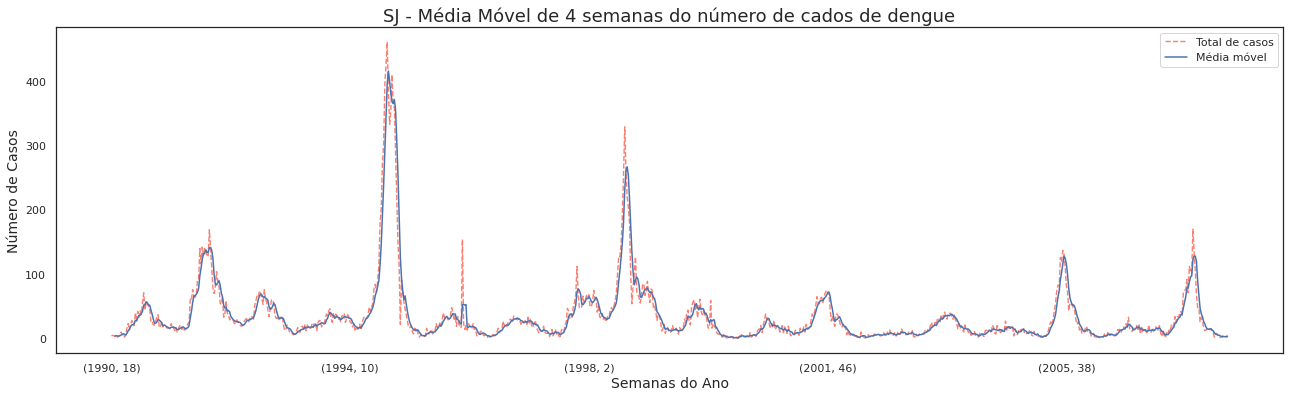

In [53]:
plt.figure(figsize=(22,6))

MM_casos['San Juan'].plot.line(lw=1.4, color='salmon', label='Total de casos', linestyle = '--')
MM_casos['MM San Juan'].plot.line(label='Média móvel')

plt.title('SJ - Média Móvel de 4 semanas do número de cados de dengue')
plt.xlabel('Semanas do Ano')
plt.ylabel('Número de Casos')

plt.legend()
plt.show()

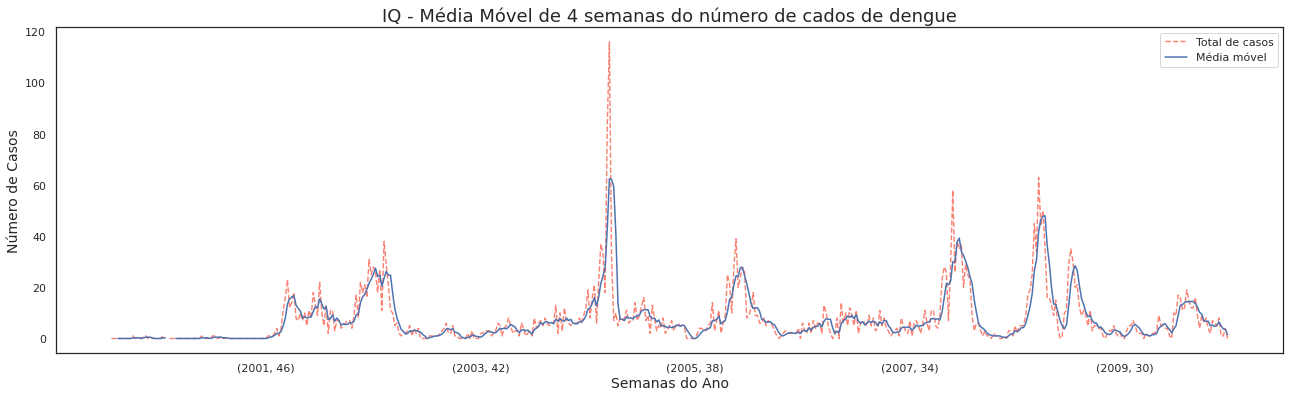

In [54]:
plt.figure(figsize=(22,6))

MM_casos['Iquitos'].plot.line(lw=1.4, color='salmon', label='Total de casos', linestyle = '--')
MM_casos['MM Iquitos'].plot.line(label='Média móvel')

plt.title('IQ - Média Móvel de 4 semanas do número de cados de dengue')
plt.xlabel('Semanas do Ano')
plt.ylabel('Número de Casos')

plt.legend()
plt.show()

### 4.3. Correlação entre atributos e rótulos

Nosso próximo passo é tentar entender como os atributos independentes afetam nossa variável alvo. A primeira coisa a se fazer é adionar `total_cases` nos dados de atributos e, em seguida, examinar a correlação dessa variável com as demais

In [55]:
# Adicionando coluna 'total_cases' dos dados de labels
sj_features['total_cases'] = sj_labels['total_cases']
iq_features['total_cases'] = iq_labels['total_cases']

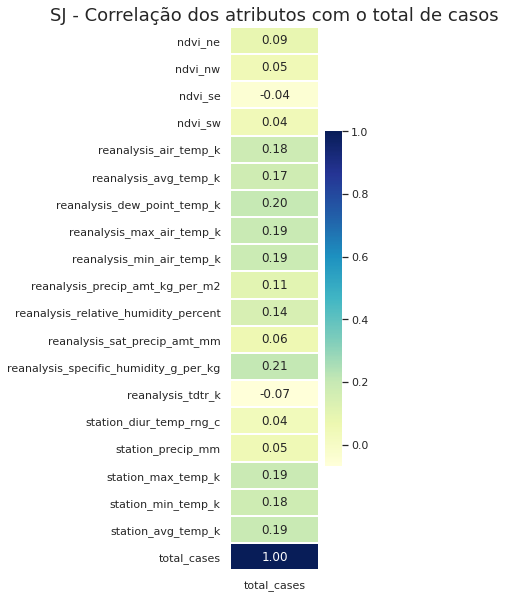

In [56]:
# Heatmap
sj_correlations = sj_features.corr()[['total_cases']]

plt.figure(figsize=(2,10))
sns.heatmap(sj_correlations, linewidths=.3, cmap="YlGnBu", annot = True, fmt = '.2f')
plt.title('SJ - Correlação dos atributos com o total de casos')
plt.show()

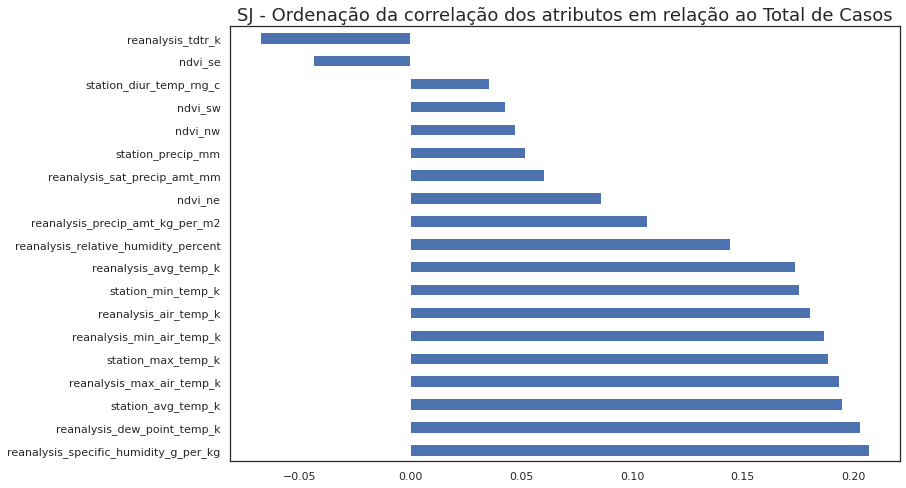

In [57]:
# Gráfico de barras horizontais ordenados pela correlação dos atributos em relação ao total_cases
plt.figure(figsize = (12,8))
sj_correlations.total_cases.drop('total_cases').sort_values(ascending=False).plot.barh()
plt.title('SJ - Ordenação da correlação dos atributos em relação ao Total de Casos')
plt.show()

Pelo Heatmap é possível ver que `total_cases` possui uma correlação baixa em relação aos atributos. O Atributo `reanalysis_tdtr_k` possui a menor correlação (-0,07) e o atributo `reanalysis_specific_humidity_g_per_kg ` possui a maior correlação (0,21). 

Todos os valores estão dentro da classificação considerada como *bem fraca* ou *fraca* para o [Coeficiente de Pearson](https://pt.wikipedia.org/wiki/Coeficiente_de_correla%C3%A7%C3%A3o_de_Pearson)

<img src="https://lh3.googleusercontent.com/proxy/LyhW-o8vIjAIs4QDFPpRRemkIRL_6zLPg7rFYBb8TviyQm0ni5bKdiByV3yZw2_xBHffyxJ3BiusTpeo7BFqguD6mQ">

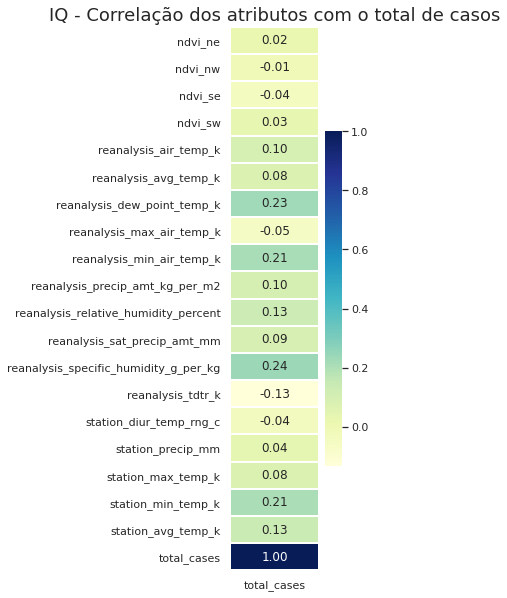

In [58]:
# Heatmap
iq_correlations = iq_features.corr()[['total_cases']]

plt.figure(figsize=(2,10))
sns.heatmap(iq_correlations, linewidths=.3, cmap="YlGnBu", annot = True, fmt = '.2f')
plt.title('IQ - Correlação dos atributos com o total de casos')
plt.show()

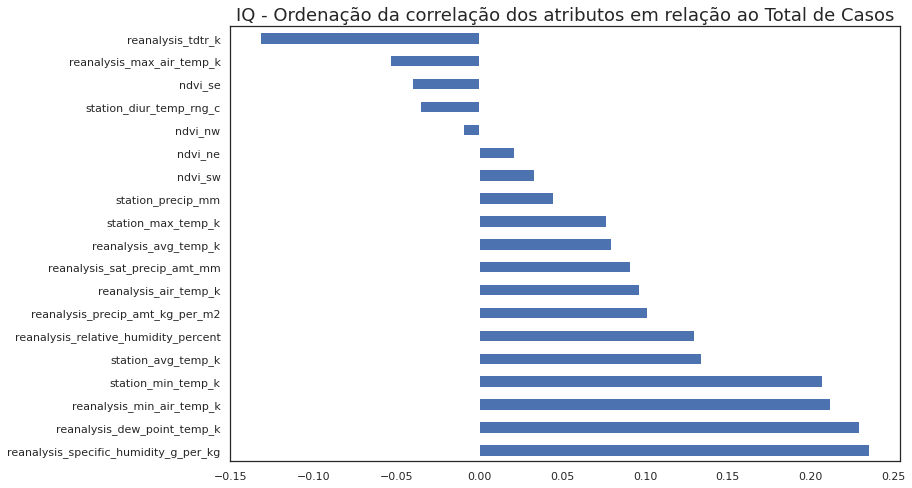

In [59]:
# Gráfico de barras horizontais ordenados pela correlação dos atributos em relação ao total_cases
plt.figure(figsize = (12,8))
iq_correlations.total_cases.drop('total_cases').sort_values(ascending=False).plot.barh()
plt.title('IQ - Ordenação da correlação dos atributos em relação ao Total de Casos')
plt.show()

Pelo Heatmap é possível ver que `total_cases` possui uma correlação baixa em relação aos atributos. O Atributo `reanalysis_tdtr_k` possui a menor correlação (-0,13) e o atributo `reanalysis_specific_humidity_g_per_kg ` possui a maior correlação (0,24), sendo os mesmo atributos que do Dataset de San Juan.

Todos os valores estão dentro da classificação considerada como *bem fraca* ou *fraca* para o [Coeficiente de Pearson](https://pt.wikipedia.org/wiki/Coeficiente_de_correla%C3%A7%C3%A3o_de_Pearson)



## 5. Observações preliminares

### Umidade

- As intensidades de correlação diferem para cada cidade, mas parecem que `reanalysis_specific_humidity_g_per_kg` e `reanalysis_dew_point_temp_k` são as mais fortemente correlacionadas com `total_cases`. Isso faz sentido: sabemos que os mosquitos se desenvolvem em climas úmidos, de modo que quanto mais úmido, mais casos espera-se ter

### Temperaturas

- À medida que as temperaturas mínimas, máximas e médias aumentam, o índice `total_cases` de dengue tende a aumentar também.

### Precipitação

- Curiosamente, as medidas de `precipitação` têm pouca ou nenhuma correlação `total_cases`, apesar das fortes correlações com os atributos de `Umidade`, conforme evidenciado pelos mapas de calor acima.